In [1]:
import torch
from flytracker import run

from flytracker.utils.param_helpers import load_frame, test_mask, test_threshold
from skimage.filters import threshold_local
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload 
%autoreload 2

In [2]:
# Location of movie
movie_path = "../../data/experiments/clement/videos/seq_1.mp4"
image = load_frame(movie_path, frame=93935, color=False)

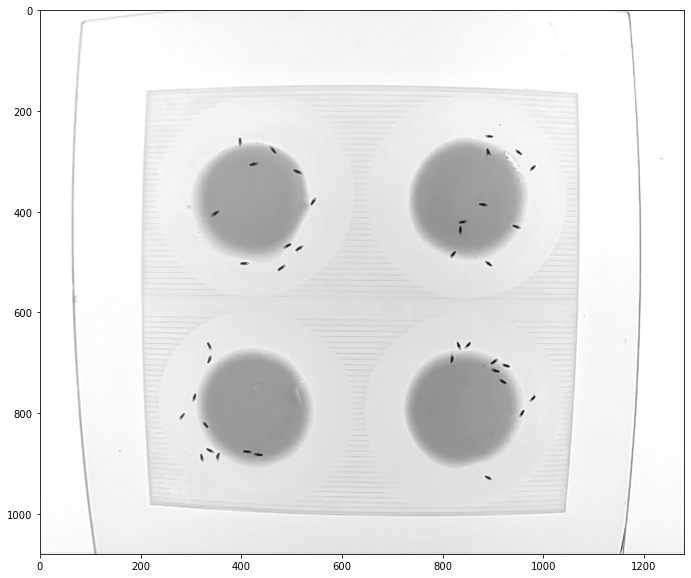

In [3]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

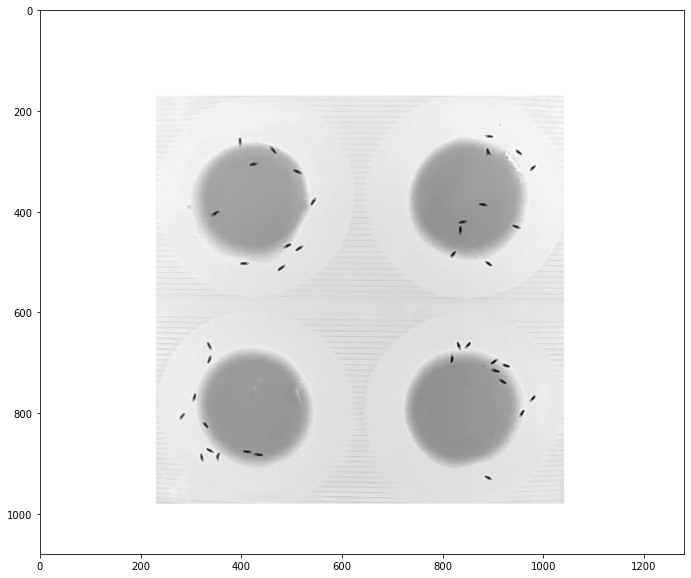

In [4]:
mask = torch.ones((1080, 1280), dtype=bool)
mask[:170, :] = 0
mask[-100:, :] = 0
mask[:, :230] = 0
mask[:, -240:] = 0

#mask[:190, :350] = 0
#mask[:195, -270:] = 0
#mask[-220:, :340] = 0
#mask[870:, 1010:] = 0

masked_image = test_mask(image, mask)

plt.figure(figsize=(15, 10))
plt.imshow(masked_image, cmap='gray')

In [5]:
def local_threshold(image, mask, threshold=50, block_size=31):
    background = threshold_local(image, block_size=block_size, method='median', )
    # we apply the mask after the background to avoid annoying edge effects
    background = test_mask(torch.tensor(background, dtype=torch.uint8), mask)
    return background - threshold 

In [6]:
local_threshold = local_threshold(image, mask, 50, 31) # feed in unmasked image!
global_threshold = 120

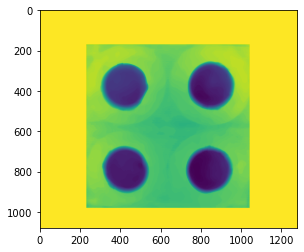

In [7]:
plt.imshow(local_threshold)

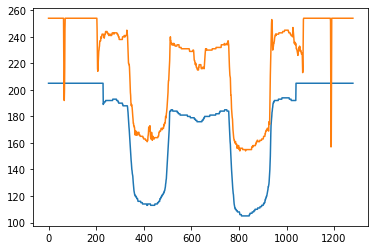

In [8]:
plt.plot(local_threshold[300, :])

plt.plot(image[300, :])

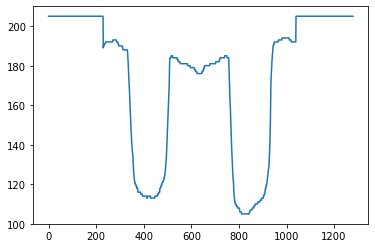

In [9]:
plt.plot(local_threshold[300, :])

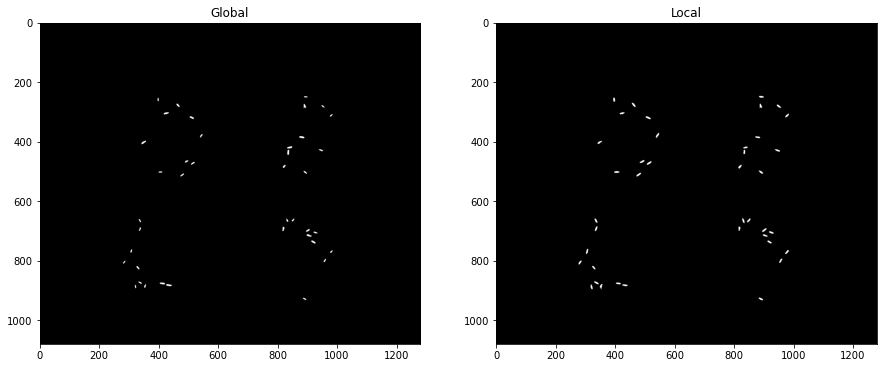

In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.title("Global")
plt.imshow(masked_image < global_threshold, cmap='gray')

plt.subplot(122)
plt.title("Local")
plt.imshow(masked_image < local_threshold, cmap='gray')

In [26]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=False,
    parallel=False,
    n_ini=100,
    threshold=120,
    n_frames=10000
)

Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
CPU times: user 23min 11s, sys: 8.83 s, total: 23min 19s
Wall time: 1min 51s


In [32]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=False,
    n_ini=100,
    threshold=120,
    n_frames=10000
)

Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
CPU times: user 11min 18s, sys: 659 ms, total: 11min 18s
Wall time: 53.4 s


In [33]:
df

,ID,x,y,frame,arena
0,0,388.688751,427.666412,100.0,0
1,1,418.105927,346.342102,100.0,0
2,2,309.391052,503.960175,100.0,0
3,3,358.989227,363.611328,100.0,0
4,4,327.629150,298.944885,100.0,0
...,...,...,...,...,...
127195,35,679.716431,372.238800,3289.0,3
127196,36,880.095337,338.619080,3289.0,3
127197,37,822.622192,297.844482,3289.0,3
127198,38,655.916565,380.416656,3289.0,3


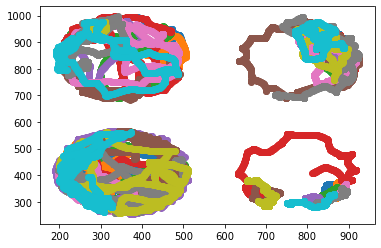

In [34]:
min_frame = 0
for ID in df.ID.unique():
    plt.plot(df.query(f"ID=={ID} and frame > {min_frame}")["x"], df.query(f"ID=={ID} and frame > {min_frame}")["y"], 'o')

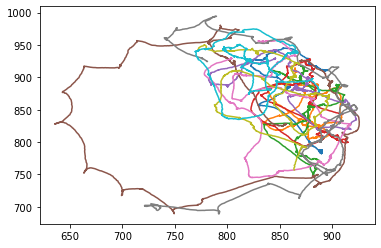

In [35]:
arena = 1
for ID in df.ID.unique():
    plt.plot(df.query(f"ID=={ID} and arena == {arena}")["x"], df.query(f"ID=={ID} and arena == {arena}")["y"], '-')

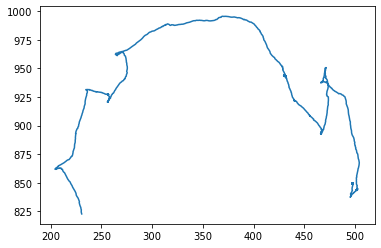

In [36]:
ID = 20
plt.plot(df.query(f"ID=={ID}")["x"], df.query(f"ID=={ID}")["y"], '-')

In [37]:
n_flies = df.ID.unique().size
X = df[["x", "y"]].to_numpy().reshape(-1, n_flies, 2)

In [38]:
diff = np.max(np.linalg.norm(np.diff(X, axis=0), axis=-1), axis=-1)

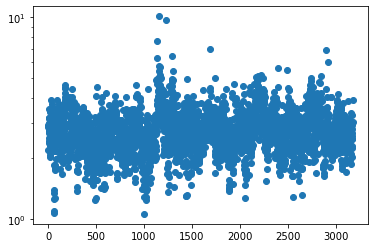

In [39]:
plt.semilogy(diff, 'o')

In [40]:
np.argmax(diff > 20)

0

In [58]:
import torch

In [59]:
X.shape

(3181, 40, 2)

In [60]:
torch.max(torch.cdist(torch.tensor(X[0]), torch.tensor(X[1])))

tensor(866.2596, dtype=torch.float64)

In [61]:
np.linalg.norm(np.sum(X[0], axis=0) - np.sum(X[1], axis=0))

6.352817251416859

array([23407.43760681, 25130.07519531])